# Workshop: Content-based Recommendation

In this workshop, we'll try content-based recommendation using features and textual descriptions of movies.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [4]:
data = pd.read_csv("drive/MyDrive/Colab Notebooks/RecSys/movies_metadata.csv", dtype = {'original_title': "string", 'overview': "string", 'tagline': "string", 'title': "string" }, encoding="utf-8", low_memory=False) 

#1. Data understanding and cleaning
Let's check the number of rows and columns, and the name of columns.

In [5]:
print(data.shape)
data.columns

(45466, 24)


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

The data types have been "guessed" by Pandas, other than those that were indicated as "string" type earlier.

In [6]:
data.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            string
overview                  string
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   string
title                     string
video                     object
vote_average             float64
vote_count               float64
dtype: object

Take a look at the actual values in the first record.

In [7]:
data.loc[0]

adult                                                                False
belongs_to_collection    {'id': 10194, 'name': 'Toy Story Collection', ...
budget                                                            30000000
genres                   [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
homepage                              http://toystory.disney.com/toy-story
id                                                                     862
imdb_id                                                          tt0114709
original_language                                                       en
original_title                                                   Toy Story
overview                 Led by Woody, Andy's toys live happily in his ...
popularity                                                       21.946943
poster_path                               /rhIRbceoE9lR4veEXuwCC2wARtG.jpg
production_companies        [{'name': 'Pixar Animation Studios', 'id': 3}]
production_countries     

We don't need columns like "homepage", "imdb_id", etc for recommendation purpose.

In [8]:
vkeep = [ 'adult', 'belongs_to_collection', 'budget', 'genres', 'id',
        'original_language', 'overview',
       'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages',  'title', 'vote_average', 'vote_count'] 
data = data[ vkeep ]
data.shape

(45466, 17)

For variable like 'belongs_to_collection', its value is a dictionary. Create a function that gets the name of the collection out of the dictionary.

In [9]:
def getValue(astring):
  if astring == 'nan':
    return astring
  if type(eval(astring)) == dict :
    return eval(astring)['name']
  else:
    return 'nan' 

In [10]:
data.loc[:, 'belongs_to_collection']= data['belongs_to_collection'].apply(lambda x: getValue(str(x)))
data['belongs_to_collection']

0                  Toy Story Collection
1                                   nan
2             Grumpy Old Men Collection
3                                   nan
4        Father of the Bride Collection
                      ...              
45461                               nan
45462                               nan
45463                               nan
45464                               nan
45465                               nan
Name: belongs_to_collection, Length: 45466, dtype: object

Values of some variables are list of dictionaries. Let's also create a function to extract the actual values of an indicated key out as list.

In [11]:
def getValues(astring, key):
  if astring == 'nan':
    return [ ]
  if type(eval(astring)) == list :
    alist = eval(astring)
    return [ eval(str(a))[key] for a in alist ]
  else:
    return [  ] 

In [12]:
data.loc[:, 'genres'] = data['genres'].apply(lambda x: getValues(str(x), 'name'))
data.loc[:, 'production_companies'] = data['production_companies'].apply(lambda x: getValues(str(x), 'name'))
data.loc[:, 'production_countries'] = data['production_countries'].apply(lambda x: getValues(str(x), 'iso_3166_1'))
data.loc[:, 'spoken_languages'] = data['spoken_languages'].apply(lambda x: getValues(str(x), 'name'))

In [13]:
data.loc[0]

adult                                                                False
belongs_to_collection                                 Toy Story Collection
budget                                                            30000000
genres                                         [Animation, Comedy, Family]
id                                                                     862
original_language                                                       en
overview                 Led by Woody, Andy's toys live happily in his ...
popularity                                                       21.946943
production_companies                             [Pixar Animation Studios]
production_countries                                                  [US]
release_date                                                    1995-10-30
revenue                                                        373554033.0
runtime                                                               81.0
spoken_languages         

#2. Recommend movie using descriptive features: K Nearest Neighbors
We'll use NearestNeighbors from sklearn, which requires all input variables to be numeric. We can see most of the variables we have here are 'object', so more data preprocessing is needed, eg. to convert binary 'adult' to be numerical, and convert categorical variables like 'genres' into a set of dummy variables.

In [14]:
data.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
id                        object
original_language         object
overview                  string
popularity                object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
title                     string
vote_average             float64
vote_count               float64
dtype: object

Let's choose a subset of variables for recommendataion: 'adult', 'genres', 'popularity', 'runtime','vote_average', 'vote_count'. 

In [15]:
#select the variables for comparison
vcompare = [ 'adult', 'genres', 'popularity', 'runtime','vote_average', 'vote_count' ] 
data_compare = data[ vcompare ] 

Drop the rows with missing values in the subset 'data_compare'. Observe that the number of rows has dropped from 45466 to 45203. We also need to reset the row index, however, we keep the original row index as an additional column so that later we can still access other information of movies (in "data") using them.

In [16]:
#drop rows with missing values
data_compare = data_compare.dropna()
data_compare.shape


(45203, 6)

In [17]:
data_compare = data_compare.reset_index()
data_compare[-5:]

,index,adult,genres,popularity,runtime,vote_average,vote_count
45198,45461,False,"[Drama, Family]",0.072051,90.0,4.0,1.0
45199,45462,False,[Drama],0.178241,360.0,9.0,3.0
45200,45463,False,"[Action, Drama, Thriller]",0.903007,90.0,3.8,6.0
45201,45464,False,[],0.003503,87.0,0.0,0.0
45202,45465,False,[],0.163015,75.0,0.0,0.0


In [18]:
data_compare.dtypes

index             int64
adult            object
genres           object
popularity       object
runtime         float64
vote_average    float64
vote_count      float64
dtype: object

Now let's convert 'adult' to be type integer with values '0' and '1', and 'popularity' to type float.

In [32]:
data_compare['adult'] = data_compare['adult'].map({'False':0, 'True':1}).astype('int64')
data_compare['popularity'] = data_compare['popularity'].astype('float64')
data_compare.dtypes

index             int64
adult             int64
genres           object
popularity      float64
runtime         float64
vote_average    float64
vote_count      float64
dtype: object

Finally we create the dummy variables for 'genres' and remove the original variable and index. The inputs to the nearest neighbors algorithm are ready.

In [33]:
#create dummy variables for 'genres'
X = pd.concat([data_compare, data_compare['genres'].str.join('|').str.get_dummies()], axis=1)
#remove the original 'genres' variable
X.pop('genres')
X.pop('index')
X.shape

(45203, 25)

In [34]:
X.dtypes

adult                int64
popularity         float64
runtime            float64
vote_average       float64
vote_count         float64
Action               int64
Adventure            int64
Animation            int64
Comedy               int64
Crime                int64
Documentary          int64
Drama                int64
Family               int64
Fantasy              int64
Foreign              int64
History              int64
Horror               int64
Music                int64
Mystery              int64
Romance              int64
Science Fiction      int64
TV Movie             int64
Thriller             int64
War                  int64
Western              int64
dtype: object

In [35]:
X.head()

,adult,popularity,runtime,vote_average,vote_count,Action,Adventure,Animation,Comedy,Crime,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,21.946943,81.0,7.7,5415.0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,17.015539,104.0,6.9,2413.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,11.712900,101.0,6.5,92.0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,3.859495,127.0,6.1,34.0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,8.387519,106.0,5.7,173.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# KNN
# Take note here the indices refer to new row indices in 'data_compare'
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
print(indices[0])
print(distances[0])

[    0 18445 22073  5209 13883]
[ 0.         31.99359125 32.7636381  44.16511179 74.80834197]


In [37]:
# to display the results
def showResults(qind, dis, ind):
  for i, d in zip(ind[qind], dis[qind]) :
    #retrieve the original row index, to access 'data'
    reali = data_compare.loc[i, 'index']
    print('=====')
    print(str(i) + '\tOriginal Row Index: ' + str(reali) + '\tDistance: ' + str(d) + '\tOriginal ID: ' + data.loc[reali, 'id'] )
    #access the values in 'data_compare' using new row index
    print(str(data_compare.loc[i]))
    print(data.loc[reali, 'title'] + "\t"+ data.loc[reali, 'overview'])

In [38]:
showResults(0, distances, indices)

=====
0	Original Row Index: 0	Distance: 0.0	Original ID: 862
index                                     0
adult                                     0
genres          [Animation, Comedy, Family]
popularity                        21.946943
runtime                                81.0
vote_average                            7.7
vote_count                           5415.0
Name: 0, dtype: object
Toy Story	Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.
=====
18445	Original Row Index: 18465	Distance: 31.993591253258458	Original ID: 77338
index                     18465
adult                         0
genres          [Drama, Comedy]
popularity            16.086919
runtime                   112.0
vote_average                8.2
vote_count      

#Wait! What has been missed out? 
The variables are in different ranges! They need to be scaled to a common range.

In [39]:
import sklearn.preprocessing as pp
scaler = pp.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
nbrs_scaled = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X_scaled)
dis_scaled, ind_scaled = nbrs_scaled.kneighbors(X_scaled)
print(ind_scaled[0])
print(dis_scaled[0])

[    0 15335  4750 21126  2991]
[0.         0.05475811 0.05718747 0.08652331 0.11451635]


In [41]:
showResults(0, dis_scaled, ind_scaled)

=====
0	Original Row Index: 0	Distance: 0.0	Original ID: 862
index                                     0
adult                                     0
genres          [Animation, Comedy, Family]
popularity                        21.946943
runtime                                81.0
vote_average                            7.7
vote_count                           5415.0
Name: 0, dtype: object
Toy Story	Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.
=====
15335	Original Row Index: 15348	Distance: 0.05475811298093958	Original ID: 10193
index                                 15348
adult                                     0
genres          [Animation, Family, Comedy]
popularity                         16.96647
runtime                        

#3. Recommend movies using text
Now let's try using text overviews to recommend movies that are similar in story line.

Movies can be in different languages. First let's make sure overviews are indeed all in English.

In [19]:
languages = set(data['original_language'])
print(len(languages))
print(languages)

93
{nan, 'en', 'el', 'zh', 'he', 'bn', 'mk', 'th', 'jv', 'nl', 'ml', 'fi', 'bs', 'bm', 'tr', 'ps', 'sl', '82.0', 'pt', 'da', 'af', 'ko', 'ky', 'te', 'uz', 'sk', 'sh', 'ja', 'it', 'tl', 'es', 'sv', 'fr', 'ca', 'de', 'ay', 'et', 'cn', 'is', 'fa', 'lt', 'sr', '104.0', 'tg', 'cs', 'hr', 'xx', 'ru', 'si', 'kk', 'eu', 'zu', 'bg', 'fy', 'cy', 'pl', 'mr', 'lb', 'eo', 'hu', 'no', 'ro', 'ms', 'ka', 'rw', 'hy', 'mt', 'vi', 'qu', 'kn', 'id', 'wo', 'ne', '68.0', 'uk', 'iu', 'ku', 'pa', 'ur', 'la', 'bo', 'hi', 'ar', 'gl', 'mn', 'sq', 'ab', 'nb', 'lo', 'sm', 'lv', 'am', 'ta'}


In [20]:
#Check that the overviews of non-English movies are also in English.
data_noten = data[data['original_language'] != 'en']
print(data_noten.shape)
data_noten['overview'][:50]

(13197, 17)


28     A scientist in a surrealist society kidnaps ch...
29     A provincial boy related to a Shanghai crime f...
32                                                  <NA>
52     Fiore, an Italian conman, arrives in post Comm...
57     Simple Italian postman learns to love poetry w...
58     The year is 1952, in Quebec City. Rachel (16),...
67     After learning of her husband's infidelities, ...
72     In France during World War II, a poor and illi...
79     Several people try to take advantage of a litt...
81     After World War II, Antonia and her daughter, ...
95     Aimlessly whiling away their days in the concr...
104                                   No overview found.
110    Keong comes from Hong Kong to visit New York f...
121    Every day, Cop 223 buys a can of pineapple wit...
122    The adventures and deceptions of a photographe...
125    The death of a prince brings a young woman bac...
129    The quirky story of a young boy's adventures g...
131    Balbuena is a genial ill

In [21]:
#drop rows with missing values
data = data.dropna()
data.shape

(44425, 17)

We can see that some movies have no review but their values of 'overview' are not empty. A good way to find such abnormal cases is to look at the number of words that a review has.

(array([ 424., 1575., 3525., 4433., 3836., 3852., 2960., 2663., 2647.,
        2802., 3170., 2268., 1628., 1275., 1006., 1112.,  842.,  788.,
         684.,  576.,  516.,  387.,  331.,  278.,  263.,  263.,  174.,
          78.,   54.,   15.]),
 array([  1. ,   7.2,  13.4,  19.6,  25.8,  32. ,  38.2,  44.4,  50.6,
         56.8,  63. ,  69.2,  75.4,  81.6,  87.8,  94. , 100.2, 106.4,
        112.6, 118.8, 125. , 131.2, 137.4, 143.6, 149.8, 156. , 162.2,
        168.4, 174.6, 180.8, 187. ]),
 <a list of 30 Patch objects>)

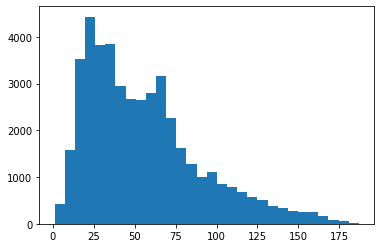

In [22]:
# How long are the overviews?
len_overview = [ len(s.split(' ')) for s in data['overview'] ]
plt.hist(len_overview, bins = 30)

In [23]:
short = [ s for s in data['overview'] if len(s.split(' ')) < 4 ]
print(len(short))

178


In [24]:
short

['No overview found.',
 'German Comedy',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview yet.',
 'No overview found.',
 'No overview found.',
 ' ',
 ' ',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 '...',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'Discovery Channel documentary',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'Return of Django',
 ' ',
 'Directed by',
 'No overview found.',
 'Finnish Documentary',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview found.',
 'No overview yet.',
 'No overview 

Now let's create a subset of the data with 3 columns - 'overview', 'title', and 'genres'.

In [25]:
text_data = data[['genres', 'title', 'overview']] 
text_data = text_data.reset_index()
text_data[-5:]

,index,genres,title,overview
44420,45460,"[Drama, Action, Romance]",Robin Hood,"Yet another version of the classic epic, with ..."
44421,45462,[Drama],Century of Birthing,An artist struggles to finish his work while a...
44422,45463,"[Action, Drama, Thriller]",Betrayal,"When one of her hits goes wrong, a professiona..."
44423,45464,[],Satan Triumphant,"In a small town live two brothers, one a minis..."
44424,45465,[],Queerama,50 years after decriminalisation of homosexual...


And combine 'overview' and 'title' as text for comparison.

In [31]:
text =  text_data['overview'] + ' ' + text_data['title']
text[0]

"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences. Toy Story"

#Representing text using TFIDF vectors

In [32]:
# Create the TF-IDF vector
vec_tfidf = TfidfVectorizer(min_df = 2, max_df=0.8, stop_words='english')

vec_overview = vec_tfidf.fit_transform(text)

In [37]:
# find top k movies most similar to q
def findMovie(q, k):
    print(text_data['title'][q])
    vals = cosine_similarity(vec_overview[q], vec_overview)
    idx_asc = vals.argsort()[0][-k:] #get index of highest sim values
    idx_dsc = idx_asc[::-1] #reverse the indices
    print(idx_dsc)
    flatv = np.sort(vals[0])
    vk_asc = flatv[-k:]
    vk_dsc = vk_asc[::-1] #reverse the list
    if(vk_dsc[1]==0):
        print("No similar movie is found")
    else:
        for v, i in zip(vk_dsc, idx_dsc):
          print(text_data['title'][i]+'\t'+str(v)+"\t"+str(i)+"\t"+str(text_data['index'][i])+'\t'+str(text_data['genres'][i]))
          print('\t'+text_data['overview'][i])

In [38]:
findMovie(0, 5)

Toy Story
[    0 15275  2977 10266 24287]
Toy Story	1.0000000000000002	0	0	['Animation', 'Comedy', 'Family']
	Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.
Toy Story 3	0.5487307348604573	15275	15348	['Animation', 'Family', 'Comedy']
	Woody, Buzz, and the rest of Andy's toys haven't been played with in years. With Andy about to go to college, the gang find themselves accidentally left at a nefarious day care center. The toys must band together to escape and return home to Andy.
Toy Story 2	0.5193233732253285	2977	2997	['Animation', 'Comedy', 'Family']
	Andy heads off to Cowboy Camp, leaving his toys to their own devices. Things shift into high gear when an obsessive toy collector named Al McWhiggen, owner of Al's Toy Barn kidnaps Woo

In [39]:
findMovie(9, 5)

GoldenEye
[   9 2854 6264 7301 7304]
GoldenEye	1.0	9	9	['Adventure', 'Action', 'Thriller']
	James Bond must unmask the mysterious head of the Janus Syndicate and prevent the leader from utilizing the GoldenEye weapons system to inflict devastating revenge on Britain.
Licence to Kill	0.1710392547036642	2854	2874	['Adventure', 'Action', 'Thriller']
	James Bond and his American colleague Felix Leiter arrest the drug lord Sanchez who succeeds in escaping and takes revenge on Felix and his wife. Bond knows but just one thing: revenge.
Battle of Britain	0.1664919044981468	6264	6293	['Action', 'Drama', 'History', 'War']
	In 1940, the Royal Air Force fights a desperate battle against the might of the Luftwaffe for control of the skies over Britain, thus preventing the Nazi invasion of Britain.
Octopussy	0.16643727475108994	7301	7330	['Adventure', 'Action', 'Thriller']
	James Bond is sent to investigate after a fellow “00” agent is found dead with a priceless Farberge egg. James bond follows th

You may also bring other features into the text for comparison, e.g. 'genres'.

In [40]:
text =  text_data['overview'] + ' ' + text_data['title'] + ' '+ [ ' '.join(g) for g in text_data['genres']] 

vec_overview = vec_tfidf.fit_transform(text)

In [41]:
findMovie(0, 5)

Toy Story
[    0 15275  2977 10266 24287]
Toy Story	1.0000000000000002	0	0	['Animation', 'Comedy', 'Family']
	Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.
Toy Story 3	0.5553336568491268	15275	15348	['Animation', 'Family', 'Comedy']
	Woody, Buzz, and the rest of Andy's toys haven't been played with in years. With Andy about to go to college, the gang find themselves accidentally left at a nefarious day care center. The toys must band together to escape and return home to Andy.
Toy Story 2	0.5247868407550742	2977	2997	['Animation', 'Comedy', 'Family']
	Andy heads off to Cowboy Camp, leaving his toys to their own devices. Things shift into high gear when an obsessive toy collector named Al McWhiggen, owner of Al's Toy Barn kidnaps Woo

In [42]:
findMovie(9, 5)

GoldenEye
[   9 2854 7301 2855 7300]
GoldenEye	1.0000000000000002	9	9	['Adventure', 'Action', 'Thriller']
	James Bond must unmask the mysterious head of the Janus Syndicate and prevent the leader from utilizing the GoldenEye weapons system to inflict devastating revenge on Britain.
Licence to Kill	0.1950552271527256	2854	2874	['Adventure', 'Action', 'Thriller']
	James Bond and his American colleague Felix Leiter arrest the drug lord Sanchez who succeeds in escaping and takes revenge on Felix and his wife. Bond knows but just one thing: revenge.
Octopussy	0.1949617336767311	7301	7330	['Adventure', 'Action', 'Thriller']
	James Bond is sent to investigate after a fellow “00” agent is found dead with a priceless Farberge egg. James bond follows the mystery and uncovers a smuggling scandal and a Russian General who wants to provoke a new World War.
Live and Let Die	0.18536394435986983	2855	2875	['Adventure', 'Action', 'Thriller']
	James Bond must investigate a mysterious murder case of a Br

#Using embeddings from Doc2Vec
Lastly, let's see how we can recommend movies based on paragraph embeddings created from the texts.

In [44]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')

#tokenize the texts first
textonly = text_data['title'] + ' ' + text_data['overview']
text_tokens = [ word_tokenize(t.lower()) for t in textonly ]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [63]:
# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(text_tokens)]
tagged_data[:10]

[TaggedDocument(words=['toy', 'story', 'led', 'by', 'woody', ',', 'andy', "'s", 'toys', 'live', 'happily', 'in', 'his', 'room', 'until', 'andy', "'s", 'birthday', 'brings', 'buzz', 'lightyear', 'onto', 'the', 'scene', '.', 'afraid', 'of', 'losing', 'his', 'place', 'in', 'andy', "'s", 'heart', ',', 'woody', 'plots', 'against', 'buzz', '.', 'but', 'when', 'circumstances', 'separate', 'buzz', 'and', 'woody', 'from', 'their', 'owner', ',', 'the', 'duo', 'eventually', 'learns', 'to', 'put', 'aside', 'their', 'differences', '.'], tags=[0]),
 TaggedDocument(words=['jumanji', 'when', 'siblings', 'judy', 'and', 'peter', 'discover', 'an', 'enchanted', 'board', 'game', 'that', 'opens', 'the', 'door', 'to', 'a', 'magical', 'world', ',', 'they', 'unwittingly', 'invite', 'alan', '--', 'an', 'adult', 'who', "'s", 'been', 'trapped', 'inside', 'the', 'game', 'for', '26', 'years', '--', 'into', 'their', 'living', 'room', '.', 'alan', "'s", 'only', 'hope', 'for', 'freedom', 'is', 'to', 'finish', 'the', '

In [64]:
## Prepare to train doc2vec model

model = Doc2Vec(vector_size=64, min_count=2, epochs=40)
model.build_vocab(tagged_data)


In [65]:
# Train the model using our data
#model.train(tagged_data, total_examples=model.corpus_count, epochs=40)

In [45]:
# As training takes a long time, here we load a doc2vec model that has been trained and saved previously.
model= Doc2Vec.load("drive/MyDrive/Colab Notebooks/RecSys/movies_doc2vec_64.model")

In [53]:
# find top K most similar documents for a test document
test_doc = word_tokenize(textonly[9].lower())
test_vec = model.infer_vector(test_doc)
results = model.docvecs.most_similar(positive=[test_vec],topn=5)
results

[(9, 0.9004906415939331),
 (13623, 0.6304832696914673),
 (1894, 0.6279374361038208),
 (2271, 0.6118921041488647),
 (27781, 0.6044468283653259)]

In [54]:
#check the results
for i, d in results:
  print(text_data['title'][i]+'\t'+"Row: "+str(i) + "\tOriginal Row: " + str(text_data['index'][i]) + '\t'+str(text_data['genres'][i]))
  print('\t'+text_data['overview'][i])

GoldenEye	Row: 9	Original Row: 9	['Adventure', 'Action', 'Thriller']
	James Bond must unmask the mysterious head of the Janus Syndicate and prevent the leader from utilizing the GoldenEye weapons system to inflict devastating revenge on Britain.
Angels & Demons	Row: 13623	Original Row: 13670	['Thriller', 'Mystery']
	Harvard symbologist Robert Langdon investigates a mysterious symbol seared into the chest of a murdered physicist. He discovers evidence of the unimaginable, the rebirth of an ancient secret brotherhood known as the Illuminati, the most powerful underground organization ever to walk the earth.
Dune	Row: 1894	Original Row: 1912	['Action', 'Science Fiction', 'Adventure']
	In the year 10,191, the world is at war for control of the desert planet Dune – the only place where the time-travel substance 'Spice' can be found. But when one leader gives up control, it's only so he can stage a coup with some unsavory characters.
Rambo III	Row: 2271	Original Row: 2291	['Action', 'Adventu

In [68]:
#The model can be saved for future usage.
#model.save("drive/MyDrive/Colab Notebooks/RecSys/movies_doc2vec_64.model")
## Load saved doc2vec model
#model= Doc2Vec.load("drive/MyDrive/Colab Notebooks/RecSys/movies_doc2vec_64.model")